In [5]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, LSTM, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K
import random
import matplotlib.pyplot as plt
import json
import keras.callbacks
import glob
from sklearn.model_selection import train_test_split
import numpy as np
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [2]:
def encode_icon(img, icon_size):
    size_last_x = 0
    encoded = []
    for y in range(icon_size):
        for x in range(icon_size):
            p = img.getpixel((x, y))
            if img.getpixel((x, y)) < 192:
                encoded.append(x)
                size_last_x = len(encoded)
        encoded.append(icon_size)
    return encoded[:size_last_x]


def decode_icon(encoded, icon_size, rows=None, stop_token=None):
    y = 0
    for idx in encoded:
        if idx == icon_size:
            y += 1
        elif idx == icon_size + 1:
            break
        else:
            x = idx
            yield x, y
            
def make_array(icons):
    res = []
    for icon in icons:
        res.extend(icon)
        res.append(33)
    return np.asarray(res)

def load_icons(train_size=0.90):
    icon_index = json.load(open('icons/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = 'icons/png32/%s.png' % icon['name']
        img = PIL.Image.open(img_path)
        if img.mode != 'L':
            img = img.convert('L')
        x.append(encode_icon(img, 32))
    x_train, x_val = train_test_split(x, train_size=train_size)
    x_train = make_array(x_train)
    x_val = make_array(x_val)
    return x_train, x_val

x_train, x_test = load_icons()
x_train.shape, x_test.shape

((1290142,), (140030,))

In [3]:
def icon_rnn_model(num_chars, num_layers, num_nodes=512, dropout=0.1):
    input = Input(shape=(None, num_chars), name='input')
    prev = input
    for i in range(num_layers):
        lstm = LSTM(num_nodes, return_sequences=True, name='lstm_layer_%d' % (i + 1))(prev)
        if dropout:
            prev = Dropout(dropout)(lstm)
        else:
            prev = lstm
    dense = TimeDistributed(Dense(num_chars, name='dense', activation='softmax'))(prev)
    model = Model(inputs=[input], outputs=[dense])
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = icon_rnn_model(34, num_layers=2, num_nodes=256, dropout=0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 34)          0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 256)         297984    
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, None, 256)         525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 34)          8738      
Total params: 832,034
Trainable params: 832,034
Non-trainable params: 0
_________________________________________________________________


In [4]:
CHUNK_SIZE = 160

def data_generator(corpus, icon_size, batch_size, chunk_size):
    X = np.zeros((batch_size, chunk_size, icon_size + 2))
    y = np.zeros((batch_size, chunk_size, icon_size + 2))
    while True:
        for row in range(batch_size):
            idx = random.randrange(len(corpus) - chunk_size - 1)
            chunk = np.zeros((chunk_size + 1, icon_size + 2))
            for i in range(chunk_size + 1):
                chunk[i, corpus[idx + i]] = 1
            X[row, :, :] = chunk[:chunk_size]
            y[row, :, :] = chunk[1:]
        yield X, y

next(data_generator(x_train, 32, 1, chunk_size=20))

(array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  1.,  

In [6]:
early = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0.03,
                              patience=3,
                              verbose=0, mode='auto')

BATCH_SIZE = 256
model.fit_generator(
    data_generator(x_train, 32, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    validation_data=data_generator(x_test, 32, batch_size=BATCH_SIZE, chunk_size=CHUNK_SIZE),
    epochs=100,
    callbacks=[early,],
    steps_per_epoch=2 * len(x_train) / (BATCH_SIZE * CHUNK_SIZE),
    validation_steps=2 * len(x_test) / (BATCH_SIZE * CHUNK_SIZE),
    verbose=2
)

Epoch 1/100
18s - loss: 3.6500 - acc: 0.0710 - val_loss: 3.5513 - val_acc: 0.0438
Epoch 2/100
17s - loss: 3.0590 - acc: 0.1909 - val_loss: 2.1740 - val_acc: 0.4109
Epoch 3/100
17s - loss: 1.3228 - acc: 0.6636 - val_loss: 1.1567 - val_acc: 0.7170
Epoch 4/100
17s - loss: 0.9252 - acc: 0.7492 - val_loss: 0.9690 - val_acc: 0.7545
Epoch 5/100
17s - loss: 0.7579 - acc: 0.7835 - val_loss: 0.9126 - val_acc: 0.7684
Epoch 6/100
17s - loss: 0.6835 - acc: 0.8021 - val_loss: 0.8794 - val_acc: 0.7841
Epoch 7/100
17s - loss: 0.6432 - acc: 0.8139 - val_loss: 0.8219 - val_acc: 0.7964
Epoch 8/100
17s - loss: 0.5926 - acc: 0.8247 - val_loss: 0.8131 - val_acc: 0.7989
Epoch 9/100
17s - loss: 0.5480 - acc: 0.8350 - val_loss: 0.8180 - val_acc: 0.8006
Epoch 10/100
17s - loss: 0.5352 - acc: 0.8413 - val_loss: 0.8576 - val_acc: 0.7984
Epoch 11/100
17s - loss: 0.5153 - acc: 0.8464 - val_loss: 0.8278 - val_acc: 0.8015
Epoch 12/100
17s - loss: 0.5114 - acc: 0.8499 - val_loss: 0.8119 - val_acc: 0.8071
Epoch 13/100


In [7]:
x_train.shape

(1290142,)

In [27]:
def generate_icons(model, num=2, diversity=1.0):
    start_index = random.randint(0, len(x_test) - CHUNK_SIZE - 1)
    generated = x_test[start_index: start_index + CHUNK_SIZE]
    sofar = None
    while num > 0:
        x = np.zeros((1, len(generated), 34))
        for t, char in enumerate(generated):
            x[0, t, char] = 1.
        preds = model.predict(x, verbose=0)[0]
        if diversity is None:
            next_index = np.argmax(preds[len(generated) - 1])
        else:
            preds = np.asarray(preds[len(generated) - 1]).astype('float64')
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            probas = np.random.multinomial(1, preds, 1)
            next_index = np.argmax(probas)
        generated[:-1] = generated[1:]
        generated[-1] = next_index
        if sofar is not None:
            if next_index == 33:
                icon = PIL.Image.new('L', (32, 32), 'white')
                for x, y in decode_icon(sofar, 32):
                    if y < 32:
                        icon.putpixel((x, y), 0)
                yield icon
                num -= 1
            else:
                sofar.append(next_index)
        if next_index == 33:
            sofar = []
    return sofar


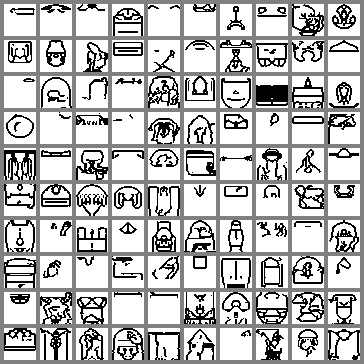

In [29]:
cols = 10
rows = 10
overview = PIL.Image.new('RGB', (cols * 36 + 4, rows * 36 + 4), (128, 128, 128))
for idx, icon in enumerate(generate_icons(model, num=cols * rows)):
    x = idx % cols
    y = idx // cols
    overview.paste(icon, (x * 36 + 4, y * 36 + 4))
overview
